In [1]:
# Fundamental Libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time
from tqdm import tqdm

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler # for scaling the data
from sklearn.model_selection import KFold, train_test_split # for generalizability analysis
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # for performance evaluation

# Plot Aesthetics
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})
plt.rcParams.update({"lines.linewidth": 0.8, "lines.markersize": 1.5})
plt.rcParams['axes.labelsize'] = 12


# Import Data & Scaling

We know import the data. We check that it is numerical since sklearn does not support categorical data yet (even for algorithms that do indeed work with categorical). Moreover, we scale the data between 0 and 1 so that the models that are sensitive to the scale of the data (such as KNN) can also be used.

In [2]:
data = pd.read_csv('encoded_data_prob.csv') 
# data.info() # check that all data is of numeric type

# Ensure that the data is scaled between 0 and 1 for the models that are sensitive to the scale of the data
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
# data


# Preliminaries for the Data Analysis

We now prepare the data for the analysi by splitting it into features and target. We also split the data into training and testing sets for general considerations (such as feature selection). 

In [3]:
# Split data into features and target
X, y = data.drop('readmitted', axis=1), data['readmitted']

# Set the random seed for reproducibility
random_seed = 0 

# General parameters definitions
n_splits = 5 # number of splits for the k-fold cross-validation
columns = X.columns

# Split data into training and testing sets for general considerations (such as feature selection)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed) # 80% (4000 instances) training and 20% (1000 instances) testing

# Feature Selection
Let us now perform feature selection to see if we can further improve the performance & efficiency of the models. We will consider two methods: 1) Embedded Methods and 2) Wrapped Methods. 

For computational reasons, we will not apply k-fold cross-validation to the feature selection methods. Instead, we will use a single split of the data into training and testing sets. Moreover, we will only use the Random Forest model for the feature selection methods, even though each model may have its own feature importances.

Sklearn source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importances-with-a-forest-of-trees


In [4]:
from sklearn.ensemble import RandomForestClassifier

rf_fs = RandomForestClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    n_estimators=256, # number of trees in the forest (default=100)
    max_depth=6, # maximum depth of the tree (default=None)
    # random_state=random_seed,
    n_jobs=-1
)

rf_fs.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=256,
                       n_jobs=-1)

## Embedded Methods

In [5]:
embedded_feature_importance = rf_fs.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_fs.estimators_], axis=0)

embedded_features_df = pd.DataFrame({
    'Feature Importance': embedded_feature_importance,
    'Std': std
}, index=columns)

# Sorting the DataFrame by 'Feature Importance' in descending order from higher to lower importance
embedded_sorted_features_df = embedded_features_df.sort_values(by='Feature Importance', ascending=False)

In [6]:
embedded_sorted_features_df # from diabetesMed (included) in 18th place to the last feature, their importance is lower than 1%
embedded_remove = {'diabetesMed', 'race_AfricanAmerican', 'citoglipton', 'rosiglitazone', 'gender', 'change', 'glimepiride', 'race_Caucasian', 'race_Other', 'pioglitazone', 'glyburide-metformin', 'chlorpropamide', 'tolazamide', 'glipizide-metformin'}
embedded_important = set(columns) - embedded_remove

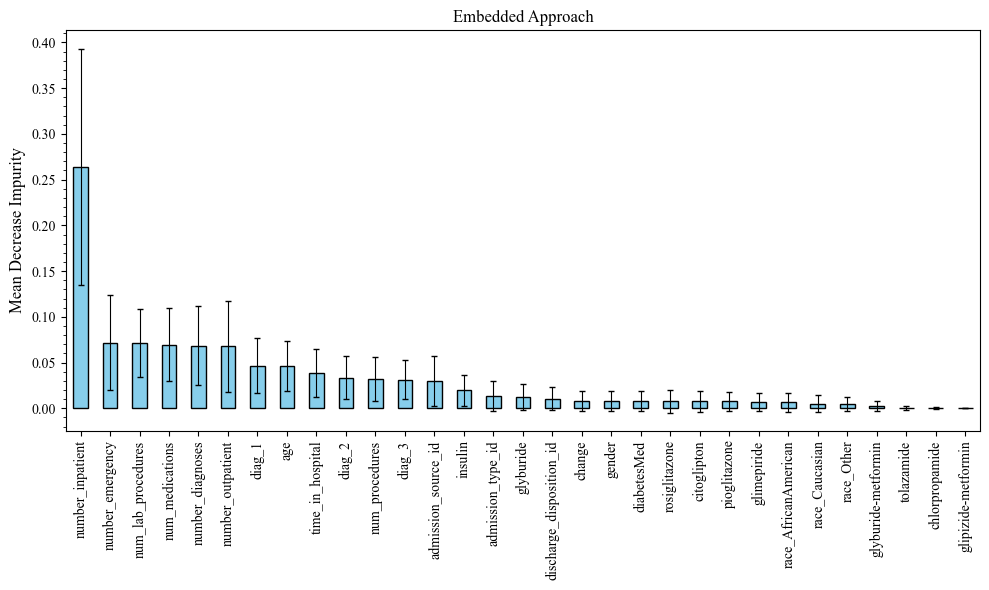

In [7]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6)) 

embedded_sorted_features_df['Feature Importance'].plot.bar(
    yerr=embedded_sorted_features_df['Std'],  
    ax=ax,
    capsize=2,
    color='skyblue',
    edgecolor='black'
)

ax.set_ylabel("Mean Decrease Impurity")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_title("Embedded Approach")
fig.tight_layout()

plt.savefig("figures/embedded_feat_select.pdf")

Let us now calculate the accuracy of the Random Forest model starting from the feature with the highest importance and adding one feature at a time. We will then plot the accuracy as a function of the number of features and choose the optimal number of features.

In [8]:
embedded_low_to_high_importance_features = list(embedded_sorted_features_df.index)
embedded_number_features = range(1, len(embedded_low_to_high_importance_features)+1)

rep = 5
embedded_accuracy_scores = np.zeros((rep, len(embedded_low_to_high_importance_features)))

for i in range(rep):
    for j in range(len(embedded_low_to_high_importance_features)):
        X_tr, X_te, y_tr, y_te = train_test_split(X[embedded_low_to_high_importance_features[:j+1]], y, test_size = 0.2) # , random_state = random_seed) # 80% training and 20% testing
    
        rf_model = RandomForestClassifier(
        criterion='entropy', # criterion to measure the quality of a split (default='gini')
        n_estimators=256, # number of trees in the forest (default=100)
        max_depth=6, # maximum depth of the tree (default=None)
        # random_state=random_seed, # random_state is not set to ensure that the model is not deterministic
        n_jobs=-1
        )
        
        rf_model.fit(X_tr, y_tr)
        y_pred = rf_model.predict(X_te)
        embedded_accuracy_scores[i, j] = accuracy_score(y_te, y_pred)

embedded_mean_accuracy = np.mean(embedded_accuracy_scores, axis=0)
embedded_std_accuracy = np.std(embedded_accuracy_scores, axis=0)

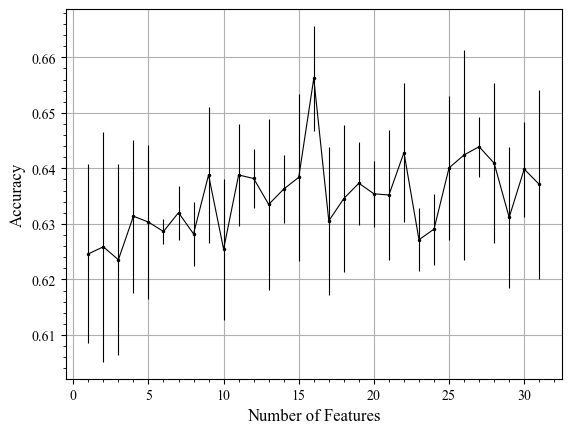

In [9]:
fig, ax = plt.subplots()
ax.errorbar(embedded_number_features, embedded_mean_accuracy, yerr=embedded_std_accuracy, marker='o', color='k', label='Accuracy')
ax.grid(True)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.grid(True)

ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")

# plt.savefig("emb_feat_select_accuracy.pdf")

plt.show()

Running several times this accuracy vs number of features plot, we see that the output is stochastic. Given the importance contribution, we consider that less than 1% is negligible, and we will consider the optimal number of features to be the first 17 in the importance order. For the different observed plots, we see good performance with 17 features, also the remaining features seem sensible.

## Wrapped Methods

In [10]:
from sklearn.inspection import permutation_importance # for assessing feature importance (wrapped method)

result = permutation_importance(rf_fs, X_train, y_train, n_repeats = 10, random_state = random_seed, scoring='accuracy', n_jobs=-1)
feature_importance_mean, feature_importance_std = result.importances_mean, result.importances_std

# Creating a DataFrame with both importances and std, using columns as the index
permutation_features_df = pd.DataFrame({
    'Feature Importance': feature_importance_mean,
    'Std': feature_importance_std
}, index=columns)

# Sorting the DataFrame by 'Feature Importance' in descending order
permutation_sorted_features_df = permutation_features_df.sort_values(by='Feature Importance', ascending=False)

In [11]:
permutation_sorted_features_df # from citoglipton (included) in 25th place to the last feature, their accuracy is of 10^-3
wrapped_remove = {'race_Other', 'citoglipton', 'pioglitazone', 'glyburide-metformin', 'glimepiride', 'chlorpropamide', 'tolazamide', 'glipizide-metformin'}
wrapped_important = set(columns) - wrapped_remove

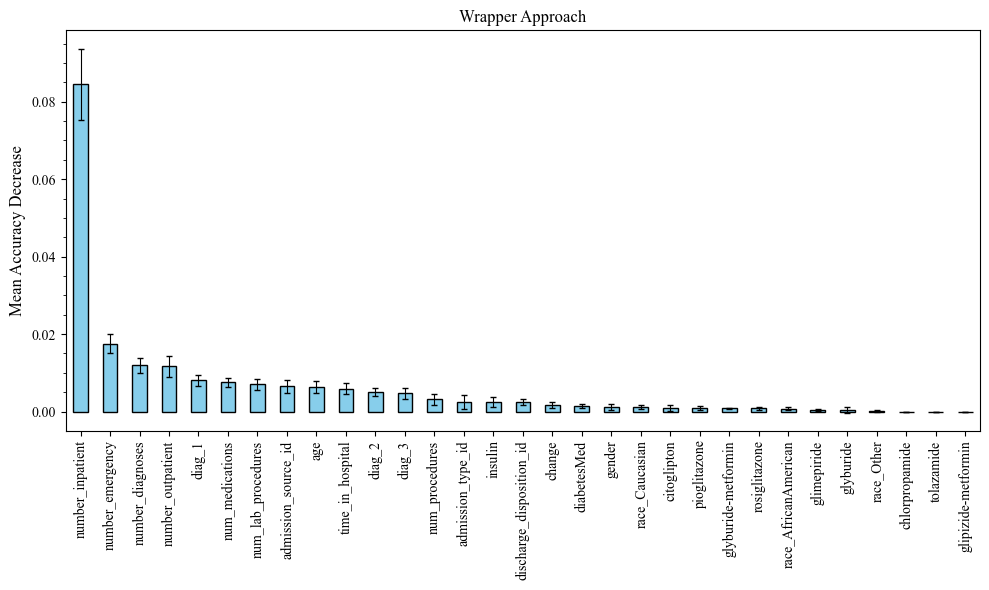

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the figure size as needed

# Plotting
permutation_sorted_features_df['Feature Importance'].plot.bar(
    yerr=permutation_sorted_features_df['Std'],  # Standard deviations for error bars
    ax=ax,
    capsize=2,
    color='skyblue',
    edgecolor='black'
)

ax.set_ylabel("Mean Accuracy Decrease")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_title("Wrapper Approach")
fig.tight_layout()

plt.savefig("figures/wrapper_feat_select.pdf")

plt.show()

In [13]:
permutation_low_to_high_importance_features = list(permutation_sorted_features_df.index)
rep = 5
permutation_accuracy_scores = np.zeros((rep, len(permutation_low_to_high_importance_features)))

for i in range(rep):
    for j in range(1, len(permutation_low_to_high_importance_features)+1):
        X_tr, X_te, y_tr, y_te = train_test_split(X[permutation_low_to_high_importance_features[:j]], y, test_size = 0.2) #, random_state = 0) # 80% training and 20% testing
        
        rf_model = RandomForestClassifier(
        criterion='entropy', # criterion to measure the quality of a split (default='gini')
        n_estimators=256, # number of trees in the forest (default=100)
        max_depth=6, # maximum depth of the tree (default=None)
        # random_state=random_seed, # random_state is not set to ensure that the model is not deterministic
        n_jobs=-1
        ) 
        
        rf_model.fit(X_tr, y_tr)
        y_pred = rf_model.predict(X_te)
        permutation_accuracy_scores[i, j-1] = accuracy_score(y_te, y_pred)

mean_accuracy = np.mean(permutation_accuracy_scores, axis=0)
std_accuracy = np.std(permutation_accuracy_scores, axis=0)

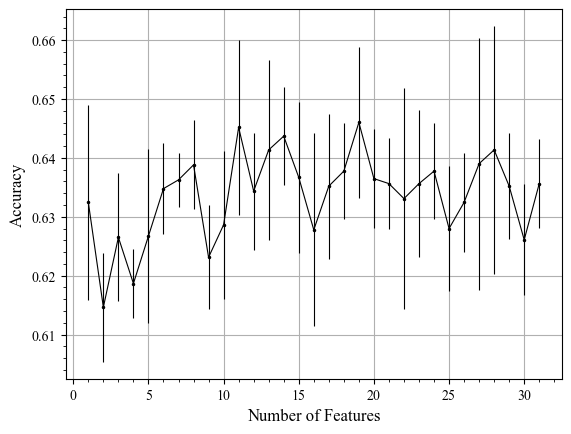

In [14]:
permutation_number_features = range(1, len(embedded_low_to_high_importance_features)+1)

fig, ax = plt.subplots()
ax.errorbar(permutation_number_features, mean_accuracy, yerr=std_accuracy, marker='o', color='k', label='Accuracy')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")

ax.grid(True)

plt.savefig("figures/permutation_feat_select_accuracy3.pdf")

plt.show()

Running several times this accuracy vs number of features plot, we see that the output is stochastic. Given the importance contribution, we consider that a contribution lower than $10^{-3}$ is negligible. Given several plots we observe that 23 features give a nice accuracy. Also, the remaining features seem sensible.

## Feature Selection Conclusions



We remove the intersection between the features selected by the two methods.

In [15]:
union_removed_features = embedded_remove.union(wrapped_remove)
intersection_removed_features = embedded_remove.intersection(wrapped_remove)

union_important_features = embedded_important.union(wrapped_important)
intersection_important_features = embedded_important.intersection(wrapped_important)

# union_features
# intersection_removed_features

# union_important_features
# intersection_important_features

In [16]:
X = X.drop(intersection_removed_features, axis=1)

# Modeling

First let us define some general functions that we will be using for the modeling. 

In [17]:
def performance(X, y, model, n_splits=10, cost_matrix = np.array([[-1, 1], [10, -1]]), shuffle = True, random_state = None):
    """
    Perform k-fold cross-validation for classification tasks.
    
    Parameters:
    - X (dataframe): The features dataframe.
    - y (dataframe): The target pandas series.
    - model: The classification model to be evaluated.
    - n_splits (int): The number of folds. Default is 10.
    - cost_matrix (array-like): The cost matrix for computing the cost. Default is [[-2, 1], [8, -2]].
    - shuffle (bool): Whether to shuffle the data before splitting. Default is True.
    
    Returns:
    - summary (dict): A dictionary containing the mean and standard deviation of the evaluation metrics.
        - accuracy: The mean and standard deviation of the accuracy.
        - precision: The mean and standard deviation of the precision.
        - recall: The mean and standard deviation of the recall.
        - f1: The mean and standard deviation of the F1 score.
        - AUC: The mean and standard deviation of the AUC.
        - cost: The mean and standard deviation of the cost.
        - training_time: The mean and standard deviation of the training time.
        - classification_time: The mean and standard deviation of the classification time.
    """
    X, y = X.to_numpy(), y.to_numpy() # convert to numpy arrays
    
    accuracy_list  = []; precision_list = []; recall_list = []; f1_list = []; AUC_list = []; cost_list = []
    
    kf = KFold(
        n_splits = n_splits, # number of folds (default=5)
        shuffle = shuffle, # whether to shuffle the data before splitting (default=False)
        random_state=random_state # random state for shuffling the data (default=None)
        )
    for train, test in kf.split(X, y): 
        # split the data (feature and class) into training and testing 
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        # fit the model
        model.fit(X_train, y_train)
        
        # Predict the class
        y_pred = model.predict(X_test)
        
        # compute the metrics for this fold
        accuracy = accuracy_score(y_test, y_pred); accuracy_list.append(accuracy) # accuracy
        precision = precision_score(y_test, y_pred); precision_list.append(precision) # precision
        recall = recall_score(y_test, y_pred); recall_list.append(recall) # recall
        f1 = f1_score(y_test, y_pred); f1_list.append(f1) # f1 score
        
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob); AUC_list.append(roc_auc) # AUC
        
        C = confusion_matrix(y_test, y_pred, labels = model.classes_)
        cost = np.sum(C * cost_matrix); cost_list.append(cost) # cost
        

    # Statistics of the metrics
    mean_accuracy, std_accuracy = np.mean(accuracy_list), np.std(accuracy_list)
    mean_precision, std_precision = np.mean(precision_list), np.std(precision_list)
    mean_recall, std_recall = np.mean(recall_list), np.std(recall_list)
    mean_f1, std_f1 = np.mean(f1_list), np.std(f1_list)
    mean_AUC, std_AUC = np.mean(AUC_list), np.std(AUC_list)
    mean_cost, std_cost = np.mean(cost_list), np.std(cost_list)
    
    
    summary = {'accuracy': (mean_accuracy, std_accuracy), 'precision': (mean_precision, std_precision), 'recall': (mean_recall, std_recall), 'f1': (mean_f1, std_f1), 'AUC': (mean_AUC, std_AUC), 'cost': (mean_cost, std_cost)}
    
    return summary

def efficiency(X, y, model, loops = 10):
    
    X, y = X.to_numpy(), y.to_numpy() # convert to numpy arrays
    
    t_trainnings = np.zeros(loops)
    t_classifications = np.zeros(loops)
    for i in range(loops):
        t0 = time.time()
        model.fit(X, y)
        t_trainnings[i] = time.time() - t0
        
        instance = X[0,:].reshape(1, -1)
        
        t0 = time.time()
        model.predict(instance)
        t_classifications[i] = time.time() - t0
    
    mean_trainning, std_trainning = np.mean(t_trainnings), np.std(t_trainnings)
    mean_classification, std_classification = np.mean(t_classifications), np.std(t_classifications)
    
    model_times = {'training_time': (mean_trainning, std_trainning), 'classification_time': (mean_classification, std_classification)}
    
    return model_times

def permutation_check(X, y, model):
    """
    Perform permutation check for evaluating model performance.

    Parameters:
    X (pandas.DataFrame): Input features.
    y (pandas.Series): Target variable.
    model: Machine learning model object with `fit` and `predict` methods.

    Returns:
    None
    """

    y_shuffled = y.sample(frac=1)
    X, y_shuffled = X.to_numpy(), y_shuffled.to_numpy() # convert to numpy arrays
    
    accuracy_list  = []
    
    kf = KFold() 
    for train, test in kf.split(X, y): 
        X_train, X_test = X[train], X[test]
        y_train, y_test = y_shuffled[train], y_shuffled[test]

        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)    
        accuracy = accuracy_score(y_test, y_pred); accuracy_list.append(accuracy) # accuracy
        

    # Statistics of the metrics
    mean_accuracy, std_accuracy = np.mean(accuracy_list), np.std(accuracy_list)

    print(f"The permutated accuracy is: {mean_accuracy} +- {std_accuracy}")



# K-Nearest Neighbours (KNN)

We have to choose 1) k (number of neighbors), 2) the distance metric, and 3) the weight function. In order to find the best k, we loop over several (odd) k's. We consider the euclidean metric and we do weight the points by the inverse of their distance.

100%|██████████| 24/24 [00:04<00:00,  5.03it/s]


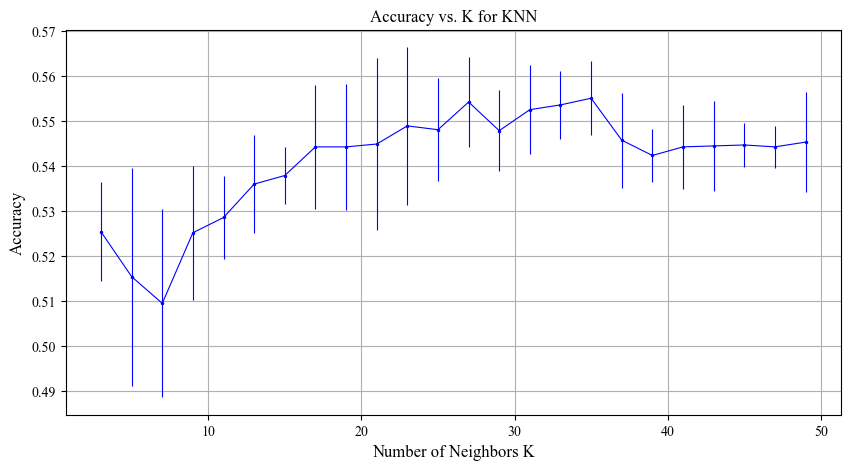

The best k is 35 with an accuracy of 0.5550828205595819 \pm 0.008176877299870648.


In [18]:
from sklearn.neighbors import KNeighborsClassifier
# Let's find the best odd k value
best_k = 0; accuracy = 0
k_min, k_max = 3, 50
k_values = range(k_min, k_max, 2)  # Odd numbers from 3 to 99
mean_accuracies = []; std_accuracies = []

knn = KNeighborsClassifier(
        weights='distance', # Weight points by the inverse of their distance
        n_jobs=-1 # Use all available CPUs
    )

for k in tqdm(k_values):
    knn.n_neighbors = k
    knn_performance = performance(X, y, knn, n_splits=n_splits, random_state=random_seed) 
    
    current_accuracy_mean, current_accuracy_std = knn_performance['accuracy'] 
    mean_accuracies.append(current_accuracy_mean)
    std_accuracies.append(current_accuracy_std)
    
    if current_accuracy_mean > accuracy:
        accuracy = current_accuracy_mean
        accuracy_std = current_accuracy_std
        best_k = k

# Plotting the accuracy for each k value
plt.figure(figsize=(10, 5))
plt.errorbar(k_values, mean_accuracies, yerr=std_accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. K for KNN')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(f"The best k is {best_k} with an accuracy of {accuracy} \pm {accuracy_std}.") 

In [19]:
knn = KNeighborsClassifier(
            n_neighbors=27, # number of neighbors to use (default=5)
            weights='distance', # weight points by the inverse of their distance (default='uniform')
            # algorithm="auto", # algorithm used to compute the nearest neighbors (default='auto')
            # p = 2, # power parameter for the Minkowski metric (default=2 which equals to the Euclidean metric)
            # metric="minkowski", # metric to use for distance computation. (default='minkowski')
            # leaf_size=1000, # leaf size passed to BallTree or KDTree (default=30)
            n_jobs=-1, # number of parallel jobs to run for neighbors search (default = None)
        ) 

knn_performance = performance(X, y, knn, n_splits = n_splits, random_state=random_seed)
knn_times = efficiency(X, y, knn, loops = 10)
permutation_check(X, y, knn)

knn_summary = {**knn_performance, **knn_times}

The permutated accuracy is: 0.5189981830585406 +- 0.0038631599142722457


In [20]:
for metric, value in knn_summary.items():
    print(f"{metric}: {value}")

accuracy: (0.5542337888070101, 0.00993218618187557)
precision: (0.5141666516191694, 0.006942253038749767)
recall: (0.43031458231201436, 0.030456067888804686)
f1: (0.46776924627772454, 0.015401445273513658)
AUC: (0.5578091187859979, 0.008634344698692845)
cost: (2104.6, 183.06567127673063)
training_time: (0.002365303039550781, 0.0007370616558877815)
classification_time: (0.002123522758483887, 0.0005455857330789054)


The maximum accuracy that I have seen is 0.55 \pm 0.01 for k = 27. In general, the accuracy is around 0.55 which is almost a random classification (0.50 accuracy) which is not very good.  The cost is 2144 \pm 129. 

Regarding the efficiency both the training and classification times are very low and quite similar. t_train = 0.0013 \pm 0.0002 and t_class = 0.00120 \pm 0.00009.


# Decision Trees (DT)

We have to choose 1) the criterion to measure the quality of a split and the 2) stopping criteria. There are more options but we will consider only these two. We will use the entropy criterion and a maximum depth of 4, although if there is no further improvement in the information gain, the tree will stop growing. As mentioned in class, the criterion does not have a significant impact on the performance of the model.

100%|██████████| 20/20 [00:02<00:00,  7.43it/s]


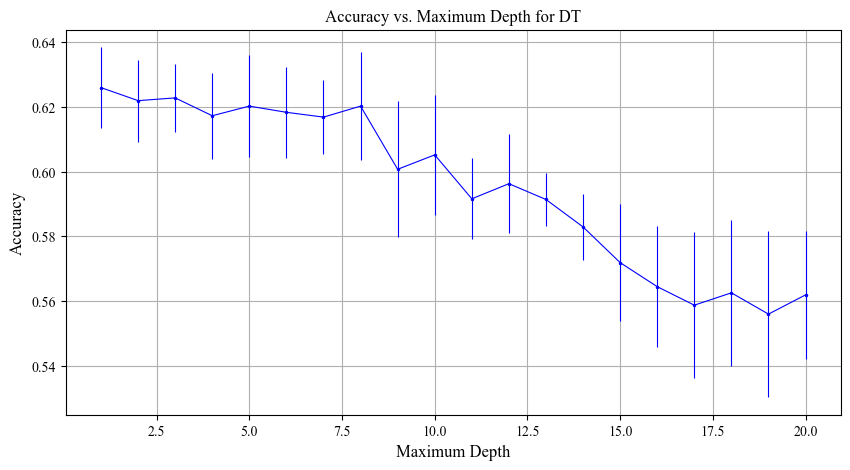

The best depth is 1 with an accuracy of 0.6259860903787657 \pm 0.012487439935991398.


In [21]:
from sklearn.tree import DecisionTreeClassifier
# Let's find the best depth value

dt = DecisionTreeClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    random_state=random_seed
)

max_depth_values = range(1, 21)  # Max depth values from 1 to 20
mean_accuracies = []; std_accuracies = []
for max_depth in tqdm(max_depth_values):
    dt.max_depth = max_depth
    dt_performance = performance(X, y, dt, n_splits=n_splits, random_state=random_seed)  # Assuming performance is your cross-validation function
    
    current_accuracy_mean, current_accuracy_std = dt_performance['accuracy']  
    mean_accuracies.append(current_accuracy_mean)
    std_accuracies.append(current_accuracy_std)
    
    if current_accuracy_mean > accuracy:
        accuracy = current_accuracy_mean
        accuracy_std = current_accuracy_std
        best_max_depth = max_depth

# Plotting the accuracy for each k value
plt.figure(figsize=(10, 5))
plt.errorbar(max_depth_values, mean_accuracies, yerr=std_accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Maximum Depth for DT')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(f"The best depth is {best_max_depth} with an accuracy of {accuracy} \pm {accuracy_std}.") 

# We get the best depth to be 1 which is counterintuitive, therefore we consider the second one which is 6 with an accuracy of 0.623 \pm 0.002.

In [22]:
dt = DecisionTreeClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    max_depth=4, # maximum depth of the tree (default=None)
    random_state = random_seed
)

dt_performance = performance(X, y, dt, n_splits = n_splits, random_state=random_seed)
dt_times = efficiency(X, y, dt, loops = 10)
permutation_check(X, y, dt)

dt_summary = {**dt_performance, **dt_times}

The permutated accuracy is: 0.5442574968535617 +- 0.015218187798433059


In [23]:
for metric, value in dt_summary.items():
    print(f"{metric}: {value}")

accuracy: (0.617284134070917, 0.013236984879679097)
precision: (0.6188605630593985, 0.04263788861536075)
recall: (0.43903340690839865, 0.06101991377290088)
f1: (0.5092575151465779, 0.029699301050947625)
AUC: (0.633672033386011, 0.013961666897931265)
cost: (1953.4, 268.47688913573177)
training_time: (0.009688305854797363, 0.0015614923196435068)
classification_time: (0.00028545856475830077, 5.048589272362631e-05)


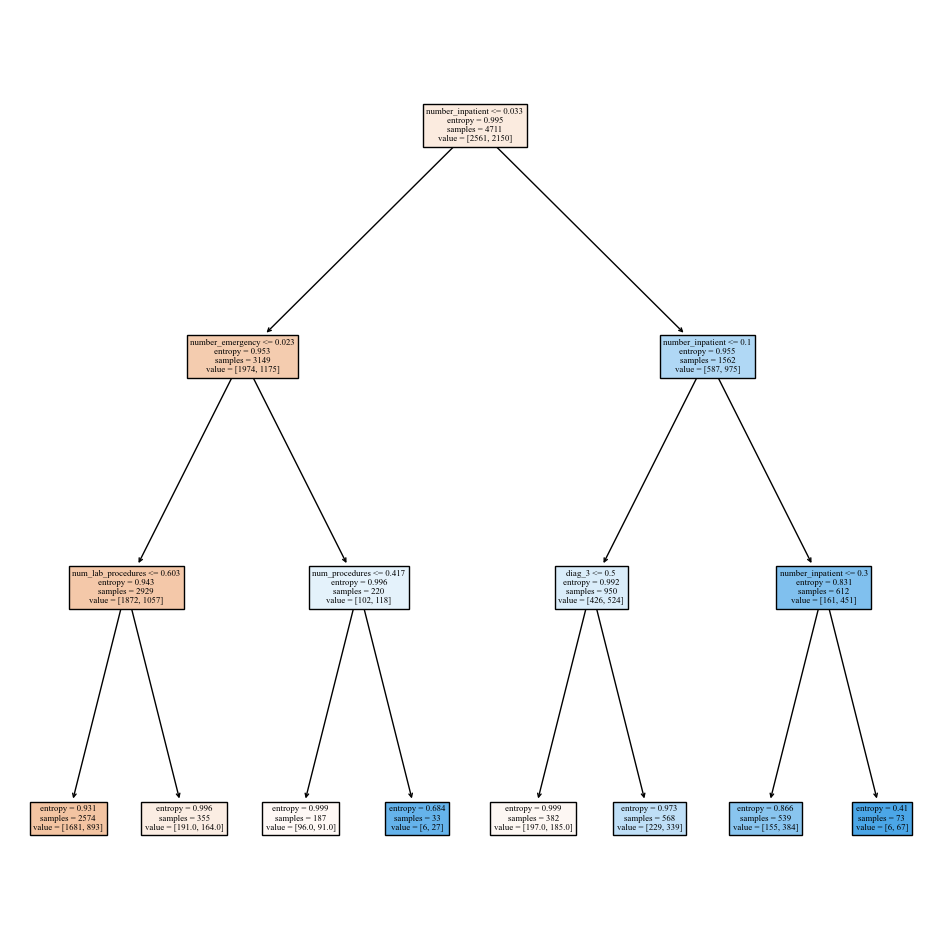

In [24]:
# Let's plot the tree.

from sklearn import tree
dt = DecisionTreeClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    max_depth=3, # maximum depth of the tree (default=None)
    random_state = random_seed
)

dt.fit(X, y)
feature_names = X.columns.tolist()

fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(dt, filled=True, feature_names=feature_names, ax=ax)
plt.show()

The maximum accuracy that I have seen is 0.63 \pm 0.01 for a maximum depth of 4. There is a decreasing tendency in the accuracy as the depth increases. The cost is 1795 \pm 152.

Regarding the efficiency both the training and classification times are very low and quite similar. t_train = 0.0082 \pm 0.0003 and t_class = 0.00023 \pm 0.00002.


# Random Forest (RF)

We have to choose 1) the criterion to measure the quality of a split, 2) the number of trees in the forest, and 3) the maximum depth of the tree. We will use the entropy, 512 trees, and a maximum depth of 6 (motivated by the decision tree).

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


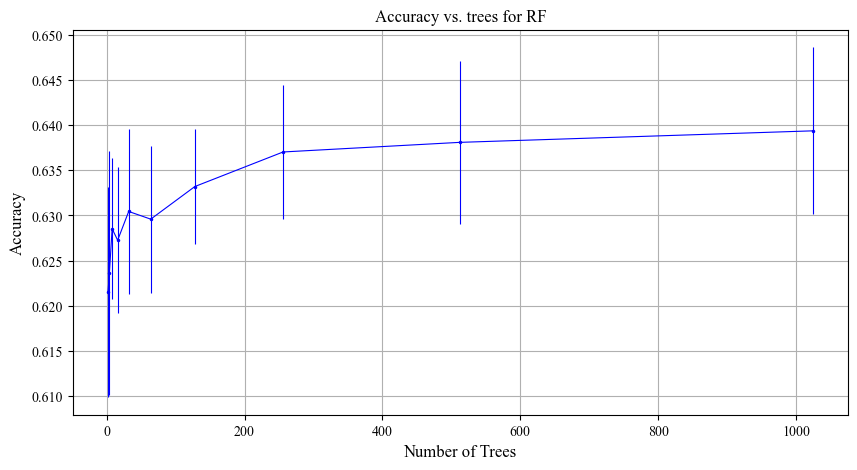

The best number of trees is 1024 with an accuracy of 0.6393580590472202 \pm 0.009248094844373889.


In [25]:
from sklearn.ensemble import RandomForestClassifier
# Let's find the best number of trees

rf = RandomForestClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    max_depth=6, # maximum depth of the tree (default=None)
    random_state=random_seed,
    n_jobs=-1
)

n_trees_values = [2**i for i in range(1, 11)]  # Number of trees from 2^1 to 2^10
mean_accuracies = []; std_accuracies = []
for n_trees in tqdm(n_trees_values):
    rf.n_estimators = n_trees
    rf_performance = performance(X, y, rf, n_splits=n_splits, random_state=random_seed)  # Assuming performance is your cross-validation function
    
    current_accuracy_mean, current_accuracy_std = rf_performance['accuracy']  # Assuming knn_performance returns a dict with accuracy list
    mean_accuracies.append(current_accuracy_mean)
    std_accuracies.append(current_accuracy_std)
    
    if current_accuracy_mean > accuracy:
        accuracy = current_accuracy_mean
        accuracy_std = current_accuracy_std
        best_n_trees = n_trees

# Plotting the accuracy for each k value
plt.figure(figsize=(10, 5))
plt.errorbar(n_trees_values, mean_accuracies, yerr=std_accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. trees for RF')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(f"The best number of trees is {best_n_trees} with an accuracy of {accuracy} \pm {accuracy_std}.")

# We get the best number of trees to be 2^9 = 512 with an accuracy of 0.638 \pm 0.007.

In [26]:
rf = RandomForestClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    n_estimators=128, # number of trees in the forest (default=100)
    max_depth=6, # maximum depth of the tree (default=None)
    random_state=random_seed,
    n_jobs=-1
)

rf_performance = performance(X, y, rf, n_splits = n_splits, random_state=random_seed)
rf_times = efficiency(X, y, rf, loops = 10)
permutation_check(X, y, rf)

rf_summary = {**rf_performance, **rf_times}

The permutated accuracy is: 0.5468068435876827 +- 0.022144517109757005


In [27]:
for metric, value in rf_summary.items():
    print(f"{metric}: {value}")

accuracy: (0.6332011716683213, 0.006324356289598129)
precision: (0.6482178720092285, 0.026063990848932975)
recall: (0.4308484396394756, 0.01524269512677692)
f1: (0.5171597317223889, 0.010920499033101723)
AUC: (0.6744227169644641, 0.019401190271302025)
cost: (1952.2, 111.3398401292188)
training_time: (0.18838186264038087, 0.038082828742516554)
classification_time: (0.015116739273071288, 0.0011969600015546856)



The accuracy is 0.64 \pm 0.01 for 128 trees. The cost is 1871 \pm 107.

Regarding the efficiency the training is one order of magnitude higher than the classification. t_train = 0.19 \pm 0.03 and t_class = 0.016 \pm 0.003.

# Gaussian Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb_performance = performance(X, y, gnb, n_splits = n_splits, random_state=random_seed)
gnb_times = efficiency(X, y, gnb, loops = 10)
permutation_check(X, y, gnb)

gnb_summary = {**gnb_performance, **gnb_times}

The permutated accuracy is: 0.49905100269501723 +- 0.017956138645910565


In [29]:
for metric, value in gnb_summary.items():
    print(f"{metric}: {value}")

accuracy: (0.611124319772691, 0.009776879376511945)
precision: (0.6806262266175936, 0.02999914509457872)
recall: (0.28038427381040193, 0.010246144901246234)
f1: (0.39673579423439387, 0.008392665840689656)
AUC: (0.6481813813693791, 0.012225671675971172)
cost: (2575.2, 97.54670676142788)
training_time: (0.004233837127685547, 0.0051125645297150895)
classification_time: (0.00031790733337402346, 0.0001942569329406988)


The accuracy is 0.61 \pm 0.02. The cost is 2562 \pm 152. 

Regarding the efficiency, we get t_train = 0.003 \pm 0.001 and t_class = 0.00025 \pm 0.00004.


# Support Vector Machines (SVM)

In [30]:
from sklearn.svm import SVC
svm = SVC(
    kernel='rbf', # kernel type to be used in the algorithm (default='rbf')
    probability=True, # whether to enable probability estimates (default=False)
    random_state=random_seed
)

svm_performance = performance(X, y, svm, n_splits = n_splits, random_state=random_seed)
svm_times = efficiency(X, y, svm, loops = 10)
permutation_check(X, y, svm)

svm_summary = {**svm_performance, **svm_times}

The permutated accuracy is: 0.5317383874475687 +- 0.011360784195394082


In [31]:
for metric, value in svm_summary.items():
    print(f"{metric}: {value}")

accuracy: (0.5986022834473707, 0.016518285483882605)
precision: (0.6154193244470261, 0.02483491778313354)
recall: (0.3237740583113926, 0.017358241490181957)
f1: (0.4238540707169743, 0.016227064716518105)
AUC: (0.6337983393427414, 0.014024942952368377)
cost: (2433.2, 176.35804489730543)
training_time: (6.504943704605102, 1.2408199367723065)
classification_time: (0.0008411407470703125, 0.00012383021242943403)



The accuracy is 0.60 \pm 0.01. The cost is 2333 \pm 177.

 Regarding the efficiency the training way longer than the classification. t_train = 5.9 \pm 0.6 and t_class = 0.00074 \pm 0.00002.


# Logistic Regression (LR)

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000,
    random_state=random_seed,
    # n_jobs=-1
)

lr_performance = performance(X, y, lr, n_splits = n_splits, random_state=random_seed)
lr_times = efficiency(X, y, lr, loops = 10)
permutation_check(X, y, lr)

lr_summary = {**lr_performance, **lr_times}

The permutated accuracy is: 0.5327981573917097 +- 0.008135705689502871


In [33]:
for metric, value in lr_summary.items():
    print(f"{metric}: {value}")

accuracy: (0.6217413819111883, 0.012784445543045564)
precision: (0.6349615825840311, 0.032799123038724703)
recall: (0.4051267792318578, 0.015000324854374447)
f1: (0.49419095864615165, 0.015115671158777792)
AUC: (0.6562194083932665, 0.012946182167091718)
cost: (2072.8, 105.27183858943474)
training_time: (0.019311189651489258, 0.0009943200635396784)
classification_time: (0.0001401662826538086, 1.051825925211021e-05)



The accuracy is 0.62 \pm 0.01. The cost is 2043 \pm 144.

Regarding the efficiency the training is two order of magnitudes higher than the classification. t_train = 0.027 \pm 0.002 and t_class = 0.00020 \pm 0.00002.

# XGBoost

In [35]:
from xgboost import XGBClassifier

hyper_params = {
    'n_estimators': 128,
    'eta': 0.1,
    'max_depth': 6,  # Commonly used depth
    # 'min_child_weight': 1,  # Default
    'subsample': 0.8,  # Typical subsample to prevent overfitting
    'colsample_bytree': 0.8,  # Typical feature subsample
    'verbosity': 1,
    'random_state': random_seed  # Ensure reproducibility
}

# Create the XGBoost model with these parameters
xgb = XGBClassifier(**hyper_params)

# Use the performance function
# Ensure X and y are correctly loaded as pandas DataFrame and Series respectively before this step
xgb_performance = performance(X, y, xgb)
xgb_times = efficiency(X, y, xgb, loops = 10)
permutation_check(X, y, xgb)

xbg_summary = {**xgb_performance, **xgb_times}

The permutated accuracy is: 0.5132672750155914 +- 0.0077871092100868285


In [36]:
for metric, value in xbg_summary.items():
    print(f"{metric}: {value}")

accuracy: (0.6221557990571809, 0.02290531590799839)
precision: (0.6014507217275975, 0.045651967532131)
recall: (0.5074073958208406, 0.04076374784766357)
f1: (0.5498208605987087, 0.03879935245178152)
AUC: (0.6562091299557188, 0.032711313865999174)
cost: (837.1, 94.30106043942455)
training_time: (0.09447317123413086, 0.013321832624632485)
classification_time: (0.0005583047866821289, 4.3180500883371756e-05)


The accuracy is 0.62 \pm 0.03. The cost is 828 \pm 115.

Regarding the efficiency the training is three order of magnitudes higher than the classification. t_train = 0.11 \pm 0.06 and t_class = 0.0006 \pm 0.0001.

# Final Results

In this final section, we present the final results. We do some tables & plots for clarity purposes. More concretely I want to do:

- Table (in LaTeX) with each of the models in the columns and in the rows the accuracy, cost, training time, and classification time.
- Bar plot summarizing the previous table.
- ROC curves for each of the models putting the AUC in the legend.

Other interesting plots might be:
- Accuracy vs classification time.
- Accuracy vs cost. 
- Training time vs classification time.

## Table & Bar Plot

In [37]:
# Let us create a list of the models and their respective results and uncertainties
models_labels = ['KNN', 'DT', 'RF', 'GNB', 'SVM', 'LR', 'XGB']

model_summaries = [knn_summary, dt_summary, rf_summary, gnb_summary, svm_summary, lr_summary, xbg_summary]

accuracies = [model_summary['accuracy'][0] for model_summary in model_summaries]
accuracies_stds = [model_summary['accuracy'][1] for model_summary in model_summaries]

AUC = [model_summary['AUC'][0] for model_summary in model_summaries]
AUC_stds = [model_summary['AUC'][1] for model_summary in model_summaries]

costs = [model_summary['cost'][0] for model_summary in model_summaries]
costs_stds = [model_summary['cost'][1] for model_summary in model_summaries]

training_times = [model_summary['training_time'][0] for model_summary in model_summaries]
training_stds = [model_summary['training_time'][1] for model_summary in model_summaries]

classification_times = [model_summary['classification_time'][0] for model_summary in model_summaries]
classification_stds = [model_summary['classification_time'][1] for model_summary in model_summaries]

In [48]:
# Table
df = pd.DataFrame({
    'Accuracy': [f"{a:.2f} ± {s:.2f}" for a, s in zip(accuracies, accuracies_stds)],
    'Cost': [f"{c:.2f} ± {cs:.2f}" for c, cs in zip(costs, costs_stds)],
    'Training Time': [f"{t:.2f} ± {ts:.2f}" for t, ts in zip(training_times, training_stds)],
    'Classification Time': [f"{ct:.5f} ± {cts:.5f}" for ct, cts in zip(classification_times, classification_stds)]
}, index=models_labels)

df_transposed = df.T

latex_code = df_transposed.to_latex()
print(latex_code)

df_transposed

\begin{tabular}{llllllll}
\toprule
 & KNN & DT & RF & GNB & SVM & LR & XGB \\
\midrule
Accuracy & 0.55 ± 0.01 & 0.62 ± 0.01 & 0.63 ± 0.01 & 0.61 ± 0.01 & 0.60 ± 0.02 & 0.62 ± 0.01 & 0.62 ± 0.02 \\
Cost & 2104.60 ± 183.07 & 1953.40 ± 268.48 & 1952.20 ± 111.34 & 2575.20 ± 97.55 & 2433.20 ± 176.36 & 2072.80 ± 105.27 & 837.10 ± 94.30 \\
Training Time & 0.00 ± 0.00 & 0.01 ± 0.00 & 0.19 ± 0.04 & 0.00 ± 0.01 & 6.50 ± 1.24 & 0.02 ± 0.00 & 0.09 ± 0.01 \\
Classification Time & 0.00212 ± 0.00055 & 0.00029 ± 0.00005 & 0.01512 ± 0.00120 & 0.00032 ± 0.00019 & 0.00084 ± 0.00012 & 0.00014 ± 0.00001 & 0.00056 ± 0.00004 \\
\bottomrule
\end{tabular}



,KNN,DT,RF,GNB,SVM,LR,XGB
Accuracy,0.55 ± 0.01,0.62 ± 0.01,0.63 ± 0.01,0.61 ± 0.01,0.60 ± 0.02,0.62 ± 0.01,0.62 ± 0.02
Cost,2104.60 ± 183.07,1953.40 ± 268.48,1952.20 ± 111.34,2575.20 ± 97.55,2433.20 ± 176.36,2072.80 ± 105.27,837.10 ± 94.30
Training Time,0.00 ± 0.00,0.01 ± 0.00,0.19 ± 0.04,0.00 ± 0.01,6.50 ± 1.24,0.02 ± 0.00,0.09 ± 0.01
Classification Time,0.00212 ± 0.00055,0.00029 ± 0.00005,0.01512 ± 0.00120,0.00032 ± 0.00019,0.00084 ± 0.00012,0.00014 ± 0.00001,0.00056 ± 0.00004


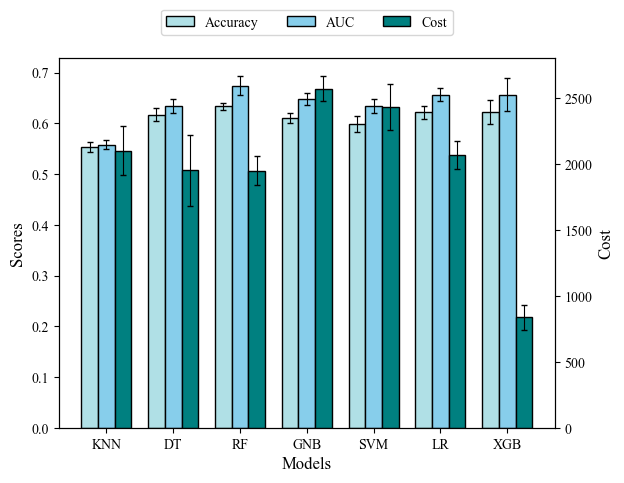

In [39]:
# Number of groups and bar width
n_groups = len(models_labels)
bar_width = 0.25

# Calculating the position of bars
index = np.arange(n_groups)
bar1 = index - bar_width
bar2 = index
bar3 = index + bar_width

# Creating the plot
fig, ax = plt.subplots()
ax2 = ax.twinx()  # Create a second y-axis

rects1 = ax.bar(bar1, accuracies, bar_width, yerr=accuracies_stds, label='Accuracy', color='powderblue', capsize=2, edgecolor='black')
rects2 = ax.bar(bar2, AUC, bar_width, yerr=AUC_stds, label='AUC', color='skyblue', capsize=2, edgecolor='black')
rects3 = ax2.bar(bar3, costs, bar_width, yerr=costs_stds, label='Cost', color='teal', capsize=2, edgecolor='black')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax2.set_ylabel('Cost')
# ax.set_title('Comparison of Model Metrics')
ax.set_xticks(index)
ax.set_xticklabels(models_labels)

# Set a common legend outside on top and centered
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.savefig("figures/model_comparison.pdf")
# Show the plot
plt.show()

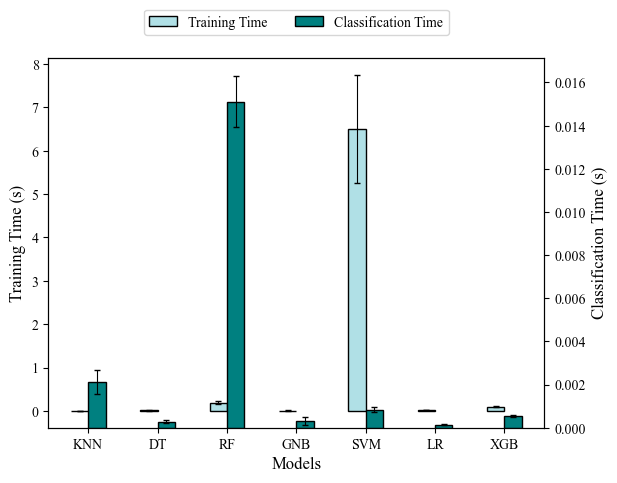

In [40]:
# Number of groups and bar width
n_groups = len(models_labels)
bar_width = 0.25

# Calculating the position of bars
index = np.arange(n_groups)

# Creating the plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

rects1 = ax1.bar(index - bar_width / 2, training_times, bar_width, yerr=training_stds, label='Training Time', color='powderblue', capsize=2, edgecolor='black')
rects2 = ax2.bar(index + bar_width / 2, classification_times, bar_width, yerr=classification_stds, label='Classification Time', color='teal', capsize=2, edgecolor='black')

# Adding labels and custom x-axis tick labels
ax1.set_xlabel('Models')
ax1.set_ylabel('Training Time (s)')
ax2.set_ylabel('Classification Time (s)')
ax1.set_xticks(index)
ax1.set_xticklabels(models_labels)

# Set a common legend outside on top and centered
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# Save the plot to a PDF
plt.savefig("figures/time_comparison.pdf")
# Show the plot
plt.show()

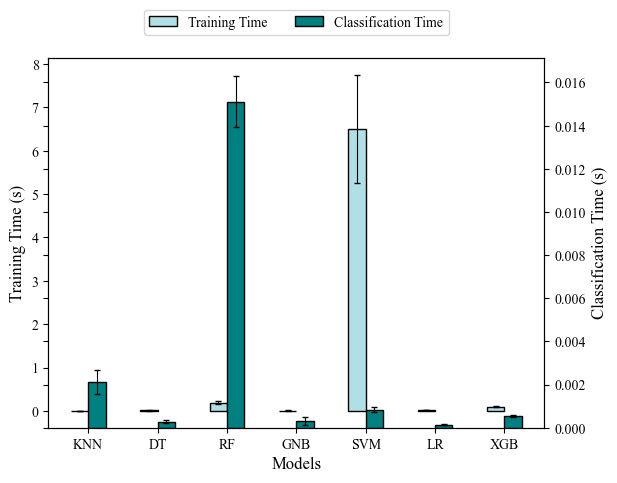

In [41]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

rects1 = ax1.bar(index - bar_width / 2, training_times, bar_width, yerr=training_stds, label='Training Time', color='powderblue', capsize=2, edgecolor='black')
rects2 = ax2.bar(index + bar_width / 2, classification_times, bar_width, yerr=classification_stds, label='Classification Time', color='teal', capsize=2, edgecolor='black')

# Adding labels and custom x-axis tick labels
ax1.set_xlabel('Models')
ax1.set_ylabel('Training Time (s)')
ax2.set_ylabel('Classification Time (s)')
ax1.set_xticks(index)
ax1.set_xticklabels(models_labels)

# Move the ticks for the second y-axis to the right side
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')  # Display tick labels on both sides

# Set a common legend outside on top and centered
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# Save the plot to a PDF
plt.savefig("figures/time_comparison.pdf")
# Show the plot
plt.show()

## ROC Curve

In [42]:
from sklearn.metrics import roc_curve, auc

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2) # , random_state = random_seed) # 80% training and 20% testing

knn = KNeighborsClassifier(
    n_neighbors=27, # number of neighbors to use (default=5)
    weights='distance', # weight points by the inverse of their distance (default='uniform')
    n_jobs=-1 # Use all available CPUs
)

dt = DecisionTreeClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    max_depth=4, # maximum depth of the tree (default=None)
    random_state=random_seed
)

rf = RandomForestClassifier(
    criterion='entropy', # criterion to measure the quality of a split (default='gini')
    n_estimators=128, # number of trees in the forest (default=100)
    max_depth=6, # maximum depth of the tree (default=None)
    random_state=random_seed,
    n_jobs=-1
)

gnb = GaussianNB()

svm = SVC(
    kernel='rbf', # kernel type to be used in the algorithm (default='rbf')
    probability=True, # whether to enable probability estimates (default=False)
    random_state=random_seed
)

log = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000,
    random_state=random_seed,
    # n_jobs=-1
)

xgb = XGBClassifier(**hyper_params)

models = {'KNN': knn, 'DT': dt, 'RF': rf, 'GNB':gnb, 'SVM': svm, 'LR': log, 'XGB': xgb}

fpr = dict(); tpr = dict(); roc_auc = dict()

for i, (model_name, model) in enumerate(models.items()):
    model.fit(X_tr, y_tr)
    y_prob = model.predict_proba(X_te)[:, 1]
    fpr[model_name], tpr[model_name], _ = roc_curve(y_te, y_prob)
    roc_auc[model_name] = auc(fpr[model_name], tpr[model_name])

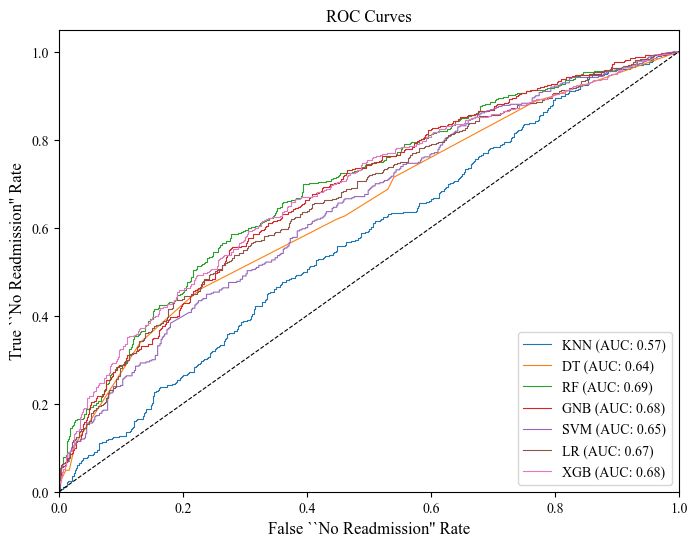

In [43]:
plt.figure(figsize=(8, 6))
for model_name, _ in models.items():
    plt.plot(fpr[model_name], tpr[model_name], label=f'{model_name} (AUC: {roc_auc[model_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel(r"False ``No Readmission'' Rate")
plt.ylabel(r"True ``No Readmission'' Rate")
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.savefig("figures/roc_curves.pdf")
plt.show()

## Other Interesting Plots

In [44]:
custom_marker_size = 4

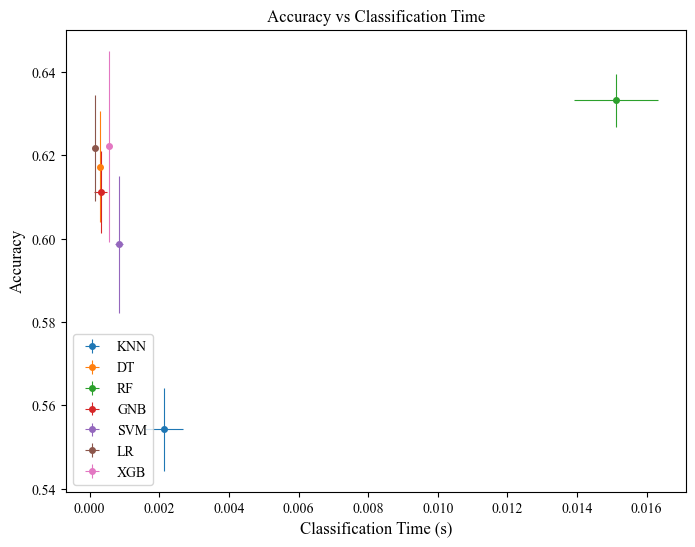

In [45]:
# 1) Accuracy vs Classification Time
plt.figure(figsize=(8, 6))
for i, label in enumerate(models_labels):
    plt.errorbar(classification_times[i], accuracies[i], xerr=classification_stds[i], yerr=accuracies_stds[i], fmt='o', markersize = custom_marker_size, label=label)
plt.title('Accuracy vs Classification Time')
plt.xlabel('Classification Time (s)')
plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)
plt.savefig("figures/accuracy_vs_classification_time.pdf")
plt.show()

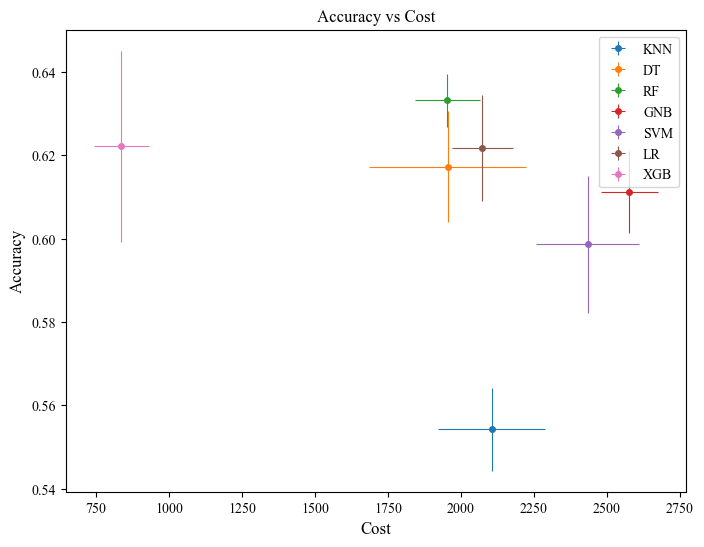

In [46]:
# 2) Accuracy vs Cost
plt.figure(figsize=(8, 6))
for i, label in enumerate(models_labels):
    plt.errorbar(costs[i], accuracies[i], xerr=costs_stds[i], yerr=accuracies_stds[i], fmt='o', markersize = custom_marker_size, label=label)
plt.title('Accuracy vs Cost')
plt.xlabel('Cost')
plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)
plt.savefig("figures/accuracy_vs_cost.pdf")
plt.show()

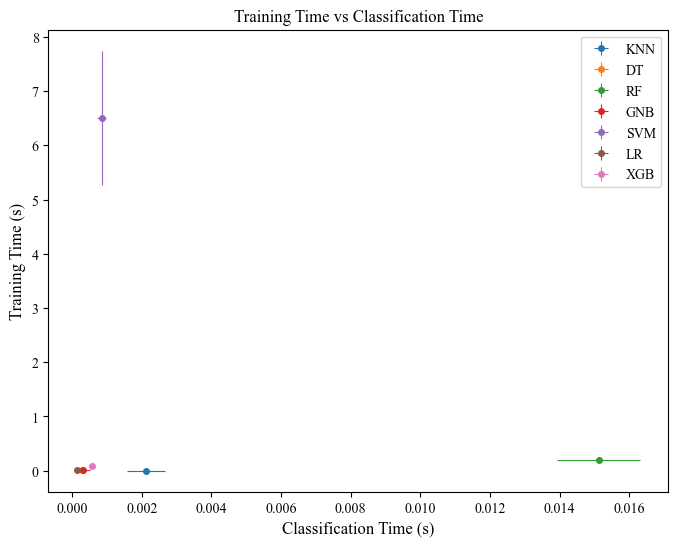

In [47]:
# 3) Training Time vs Classification Time
plt.figure(figsize=(8, 6))
for i, label in enumerate(models_labels):
    plt.errorbar(classification_times[i], training_times[i], xerr=classification_stds[i], yerr=training_stds[i], fmt='o', markersize = custom_marker_size, label=label)
plt.title('Training Time vs Classification Time')
plt.xlabel('Classification Time (s)')
plt.ylabel('Training Time (s)')
plt.legend()
# plt.grid(True)
plt.savefig("figures/training_vs_classification_time.pdf")
plt.show()